In [13]:
## Imports 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, make_scorer, f1_score, recall_score, precision_score, roc_curve, auc, precision_recall_curve, average_precision_score, cohen_kappa_score, mean_absolute_error, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import os


## Data Preprocessing and Cleansing to Ensure High-Quality Insights

In [ ]:
### 1) Début du téléchargement des données brutes

file_path = r"C:\Users\Maxime\Desktop\Fragilité\GSTRIDE_database_avec_capteurs.csv"

df = pd.read_csv(
    file_path,
    sep=';',
    decimal=',',
    parse_dates=False,           # 👈 Désactivation de data parsing
    infer_datetime_format=False  # 👈 Désactivation de auto-date definition
)


### 2) Suppression des colonnes inutiles

columns_to_drop = [
    "Date (Month-YY)", 
    "ID (VNNN) -Volunteer index", 
    "Device Id. (identifier)"
]

df = df.drop(columns=columns_to_drop, errors='ignore')


### 3) Préparation des données et imputation des valeurs manquantes

columns_to_clean = {
    "Balance test (index) — Index from 0 to 4; 0: lowest balance; 4: highest balance": 0,
    "Chair stand test (index) — Index from 0 to 4; 0: large time to stand up (lowest force); 4: short time to stand up (highest force)": 0,
    "Timed up and go (TUG) test  — test time duration": 0,
    "Short Falls Efficacy Scale International test  — Index from 7 to 28; 7: no concern about falling; 28: severe concern about falling": 28,
}

column_to_clean_and_replacing_with_mean = "Manual force  (kg)"

col_name = column_to_clean_and_replacing_with_mean

if col_name in df.columns:
    
    # Étape 1 : Remplacement des valeurs manquantes string explicites par NaN
    values_to_replace = ['-', 'Incapable']
    df[col_name] = df[col_name].replace(values_to_replace, np.nan)
    
    # Étape 2: Nous remplaçons toutes les virgules par des points.
    df[col_name] = df[col_name].astype(str).str.replace(',', '.', regex=False)

    # Étape 3 : Conversion de la colonne en type numérique (float) # Maintenant, tous les nombres fractionnaires corrects sont convertis en float.
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce') 
    
    # Étape 4 : Calcul et imputation des valeurs manquantes par la moyenne # Nous calculons la valeur moyenne à partir des données numériques existantes.
    mean_value = df[col_name].mean()
    
    if not pd.isna(mean_value):
        # Nous remplissons uniquement les valeurs qui sont devenues NaN (c'est-à-dire nos 'Incapable' et '-')
        df[col_name] = df[col_name].fillna(round(mean_value, 2))
    else:
        print("❌ Impossible de calculer la moyenne : toutes les valeurs de la colonne ne sont pas numériques")
    
else:
    print(f"❌ La colonne '{col_name}' est introuvable dans le DataFrame")




for col, fill_value in columns_to_clean.items():
    if col in df.columns:
        print(f"⏳ Traitement de la colonne: '{col}'...")
        
        # Conversion de toutes les valeurs non-numériques en NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        #  Conversion de tous les NaN en valeur cible.
        df[col] = df[col].fillna(fill_value)
    else:
        print(f"❌ La colonne '{col}' n'a pas été trouvée dans le DataFrame.")



In [ ]:

### 4)  Conversion des colonnes de type 'object' en colonnes numériques.

# 4.1 Les colonnes où les valeurs manquantes ('Incapable', '-') sont remplacées par 'NON'.
cols_replace_with_NO = [
    "Unintentional weight loss (YES/NO) — YES: lost more than 4,5 kg during the last year; NO: otherwise",
    "Low energy and resistance (YES/NO) — YES: at least two days per week with low energy or resistance; NO: otherwise",
    "Low activity level (YES/NO) — YES: (M) walks less than 3 h/week or (F) walks less than 1h/week; NO: otherwise",
    "Manual force clinical assessment (YES/NO)  — YES: force (kg) < threshold (kg) (thresholds depend on the sex and body-mass index); NO: otherwise"
]

# 4.2 Toutes les colonnes binaires (après nettoyage) qui doivent être encodées en 1/0.
binary_cols_to_encode = [
    "Unintentional weight loss (YES/NO) — YES: lost more than 4,5 kg during the last year; NO: otherwise",
    "Low energy and resistance (YES/NO) — YES: at least two days per week with low energy or resistance; NO: otherwise",
    "Low activity level (YES/NO) — YES: (M) walks less than 3 h/week or (F) walks less than 1h/week; NO: otherwise",
    "Manual force clinical assessment (YES/NO)  — YES: force (kg) < threshold (kg) (thresholds depend on the sex and body-mass index); NO: otherwise",
    
    "Sex (M/ F)",
    "Falls during the last year - prior to test (YES/NO) — YES: they fell during the last year; NO: otherwise",
    "Living in a nursing home (YES/NO)",
    "Gait speed clinical assessment (YES/NO) — YES: gait speed (m/s) < threshold (m/s) (thresholds depend on the sex and height); NO: otherwise",
]

# 4.3 Les colonnes catégorielles pour l'OHE (One-Hot Encoding).
categorical_cols_to_ohe = [
    "Type of device (CSIC/Gaitup) — CSIC: ad-hoc made; Gaitup: from gaitup commertial brand",
    "Location (Consultation, Nursing home, Familiar)",
    "Test surface (type of surface)  Plane: inside of bulidings; Varied: outside"
]


# 4.4 Application du remplacement par 'NON'
for col in cols_replace_with_NO:
    if col in df.columns:
       
        df[col] = df[col].astype(str) 
       # Remplacement de 'Incapable' et '-' par 'NON' (conversion en majuscules au préalable pour plus de fiabilité).
        df[col] = df[col].str.upper().replace(['INCAPABLE', '-'], 'NO')
    else:
        print(f"   ❌ '{col}' pas trouvé")
        
# 4.5 Normalisation de toutes les colonnes binaires et catégorielles (suppression des espaces).
for col in binary_cols_to_encode + categorical_cols_to_ohe:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()


# 4.6 Encodage binaire (Label Encoding)
for col in binary_cols_to_encode:
    if col in df.columns:
        
        # Règles spéciales pour 'Sex' : M=1, F=0
        if col == "Sex (M/ F)":
            mapping = {'M': 1, 'F': 0}
        # Tous les autres OUI/NON : OUI=1, NON=0
        else:
            mapping = {'YES': 1, 'NO': 0}

        # Nous effectuons l'encodage
        df[col] = df[col].replace(mapping)
        
        # Si d'autres valeurs de chaîne de caractères subsistent après le remplacement, elles deviendront NaN (par exemple, "NAN")
        df[col] = pd.to_numeric(df[col], errors='coerce') 
        
        # Conversion au type entier (Int64) qui prend en charge les valeurs NaN
        df[col] = df[col].astype('Int64', errors='ignore')

    
# 4.7 Encodage catégoriel (One-Hot Encoding)
df = pd.get_dummies(
    df, 
    columns=categorical_cols_to_ohe, 
    prefix=[f"{col[:10]}" for col in categorical_cols_to_ohe], # Nous raccourcissons les préfixes pour faciliter la lecture/pour plus de commodité.
    dtype=int, 
    dummy_na=False # Nous ne créons pas de colonne distincte pour les valeurs manquantes.
)


## Data Processing for Predicting Presence and Severity of Frailty in Older Adults

In [ ]:


CHEMIN_FICHIER = r'C:\Users\Maxime\Desktop\Fragilité\pack\Données_nettoyées_sans_capteurs____index_de_fragilité_unifiée.csv'
TARGET_COLUMN = 'Frailty index from 0 to 5; 0: lowest failty; 5: highest failty'

try:
    df = pd.read_csv(CHEMIN_FICHIER, sep=';')
    print(f"Chargement réussi du fichier : {os.path.basename(CHEMIN_FICHIER)}")
    print("-" * 50)

except FileNotFoundError:
    print(f"ERREUR: Fichier non trouvé à l'emplacement spécifié : {CHEMIN_FICHIER}")


Chargement réussi du fichier : Données_nettoyées_sans_capteurs____index_de_fragilité_unifiée.csv
--------------------------------------------------


In [ ]:
# --- 2. Préparation de X et y --- valeur cible 0/1 ---

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN].astype(int) 

# Vérification que la colonne cible ne contient que 0 ou 1
if not (y.isin([0, 1])).all():
    print("ATTENTION : La colonne cible contient des valeurs différentes de 0 ou 1. Il est nécessaire de vérifier le nettoyage.")

# Séparation des données (70% entraînement, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Données séparées : {len(X_train)} échantillons pour l'entraînement, {len(X_test)} échantillons pour le test.")
print("-" * 50)


# --- 3. ENTRAÎNEMENT DU MODÈLE XGBOOST ---

modele_xgb_binary = xgb.XGBClassifier(
    objective='binary:logistic', 
    use_label_encoder=False, 
    eval_metric='logloss',
    n_estimators=100,
    random_state=42,
    tree_method='hist'
)

# Création du pipeline avec une NOUVELLE étape Imputer
pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Étape 1 : Remplissage des NaN avec la médiane
    ('scaler', StandardScaler()),                   # Étape 2 : Normalisation des caractéristiques
    ('xgb', modele_xgb_binary)                      # Étape 3 : Modèle XGBoost
])

print("Démarrage de l'entraînement du modèle XGBoost Binaire...")
pipeline_xgb.fit(X_train, y_train)

# Prédiction (classes 0/1)
predictions = pipeline_xgb.predict(X_test)
# Prédiction des probabilités (utile pour ROC AUC)
predictions_proba = pipeline_xgb.predict_proba(X_test)[:, 1] 


# --- 4. ÉVALUATION ---

print("\n" + "=" * 60)
print("--- ÉVALUATION DU MODÈLE XGBoost ---")

# A. Exactitude (Accuracy)
accuracy = accuracy_score(y_test, predictions)

# B. ROC AUC (Aire sous la courbe)
# Valeur idéale = 1.0 ; Prédiction aléatoire = 0.5
roc_auc = roc_auc_score(y_test, predictions_proba)

# C. Rappel (Recall) - Combien de malades réels avons-nous détectés ?
# Cette métrique est critique en médecine : minimiser les faux négatifs.
recall = recall_score(y_test, predictions)

# D. F1-score - Métrique équilibrée entre précision et rappel
f1 = f1_score(y_test, predictions)

# E. Précision (Precision) - Parmi les malades prédits, combien le sont réellement ?
precision = precision_score(y_test, predictions)

# Affichage des résultats
print(f"1. Exactitude (Accuracy) : {accuracy:.4f}")
print(f"2. ROC AUC (Aire sous la courbe) : {roc_auc:.4f}")
print(f"3. Rappel (Recall) : {recall:.4f}")
print(f"4. Précision : {precision:.4f}")
print(f"5. F1-Score : {f1:.4f}")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, predictions))
print("=" * 60)



## Key Feature Analysis and Visualizations for Predicting Frailty Presence (0/1) with XGBoost

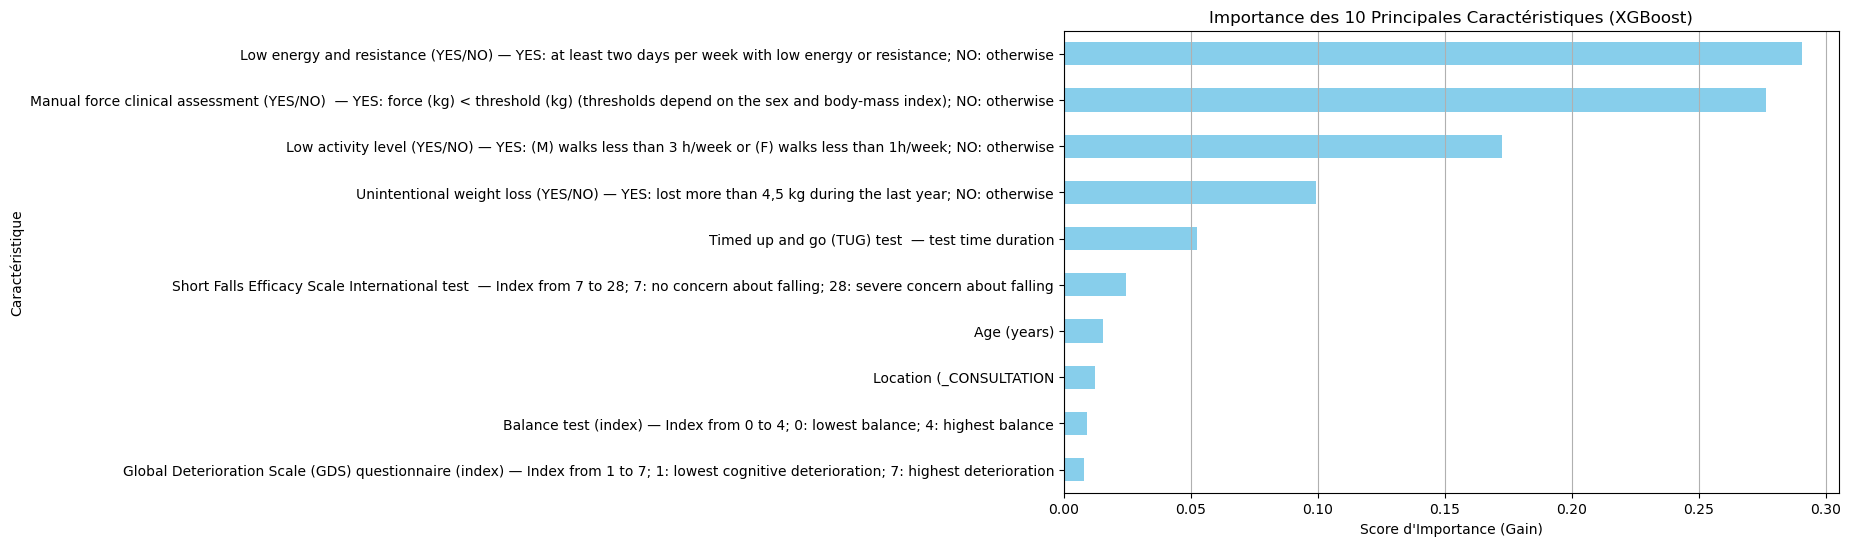

In [ ]:
# On suppose que votre meilleur XGBoost entraîné se trouve dans 'pipeline_xgb'
# Extraction du modèle XGBoost depuis le pipeline
modele_xgb_binary = pipeline_xgb.named_steps['xgb']

# Obtention de l'importance des caractéristiques
feature_importances = pd.Series(
    modele_xgb_binary.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False).head(10)  # Affichage du TOP-10

# Visualisation du graphique
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Importance des 10 Principales Caractéristiques (XGBoost)')
plt.xlabel("Score d'Importance (Gain)")
plt.ylabel('Caractéristique')
plt.grid(axis='x')
plt.show()

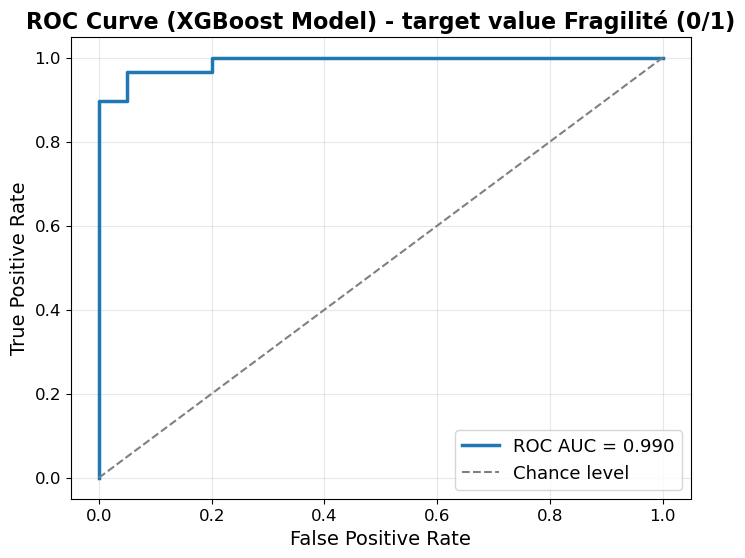

In [ ]:
# Probabilités prédites
y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# --- GRAPHIQUE ---
plt.figure(figsize=(8, 6))

plt.plot(
    fpr, tpr,
    color="#1f77b4",
    linewidth=2.5,
    label=f"ROC AUC = {roc_auc:.3f}"
)

# Ligne du classifieur aléatoire
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color="gray",
         linewidth=1.5,
         label="Niveau aléatoire")

# Mise en forme
plt.title("Courbe ROC (Modèle XGBoost) - Valeur cible Fragilité (0/1)", fontsize=16, fontweight="bold")
plt.xlabel("Taux de faux positifs (False Positive Rate)", fontsize=14)
plt.ylabel("Taux de vrais positifs (True Positive Rate)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(alpha=0.3)
plt.legend(fontsize=13)

plt.show()

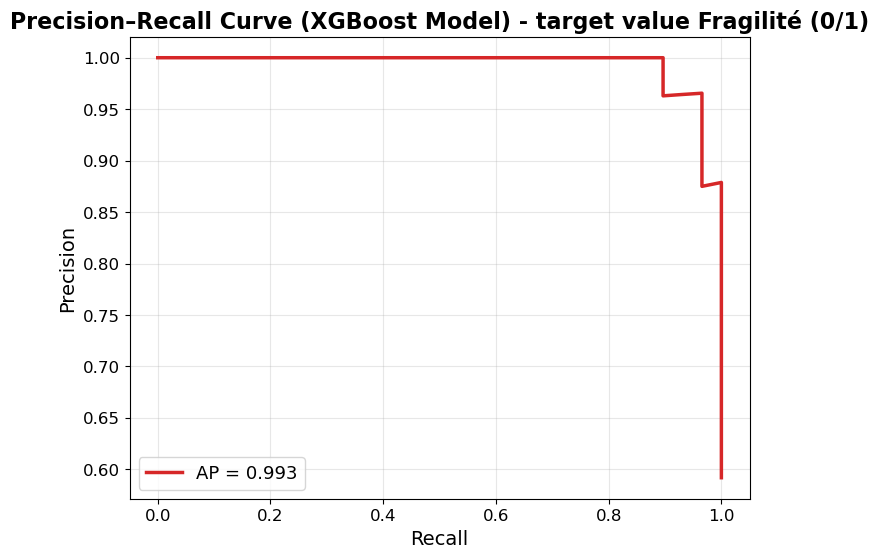

In [ ]:
# Probabilités prédites pour la classe 1
y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

# Calcul de la courbe
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Average Precision (AP)
ap_score = average_precision_score(y_test, y_proba)

# --- GRAPHIQUE ---
plt.figure(figsize=(8, 6))

plt.plot(
    recall, precision,
    color="#d62728",
    linewidth=2.5,
    label=f"AP = {ap_score:.3f}"
)

plt.title("Courbe Précision–Rappel (Modèle XGBoost) - Valeur cible Fragilité (0/1)", fontsize=16, fontweight="bold")
plt.xlabel("Rappel (Recall)", fontsize=14)
plt.ylabel("Précision (Precision)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(alpha=0.3)
plt.legend(fontsize=13)

plt.show()

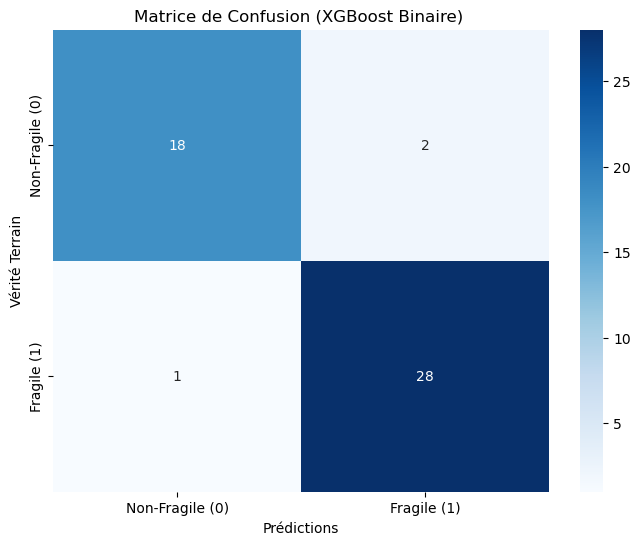

In [ ]:
# 1. Calcul de la matrice de confusion
cm = confusion_matrix(y_test, predictions)
labels = ['Non-Fragile (0)', 'Fragile (1)']  # Étiquettes pour les axes

# 2. Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,        # Afficher les nombres dans les cellules
    fmt='d',           # Format des nombres (entiers)
    cmap='Blues',      # Palette de couleurs
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel('Prédictions')
plt.ylabel('Vérité Terrain')
plt.title('Matrice de Confusion (XGBoost Binaire)')
plt.show()

## Data Processing for Frailty Level Analysis with XGBoost

In [2]:
### XGBoost pour la variable cible 0-5

# --- 1. DÉFINITION DU CHEMIN ET CHARGEMENT ---
CHEMIN_FICHIER = r'C:\Users\Maxime\Desktop\Fragilité\pack\Données_nettoyées_sans_capteurs_____index_de_fragilité_initial.csv'
# Nom original de la colonne cible (indice 0-5)
TARGET_COLUMN = 'Frailty index from 0 to 5; 0: lowest failty; 5: highest failty'
NUM_CLASSES = 6  # Classes : 0, 1, 2, 3, 4, 5

try:
    df = pd.read_csv(CHEMIN_FICHIER, sep=';')
    print(f"Chargement réussi du fichier : {os.path.basename(CHEMIN_FICHIER)}")
    print("-" * 50)
except FileNotFoundError:
    print(f"ERREUR : Fichier non trouvé à l'emplacement spécifié : {CHEMIN_FICHIER}")
    exit()

# --- 2. PRÉPARATION ET SÉPARATION DE X ET y ---
# X (Caractéristiques)
X = df.drop(columns=[TARGET_COLUMN])
# y (Variable cible)
y = df[TARGET_COLUMN].astype(int) 

# Séparation des données (70% entraînement, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Données séparées : {len(X_train)} échantillons pour l'entraînement, {len(X_test)} pour le test.")
print("-" * 50)

# --- 3. ENTRAÎNEMENT DU MODÈLE XGBOOST (Classification Multiclasse) ---
modele_xgb_multi = xgb.XGBClassifier(
    # IMPORTANT : objective='multi:softmax' pour la classification multiclasse
    objective='multi:softmax',
    num_class=NUM_CLASSES,     # 6 classes
    use_label_encoder=False,
    eval_metric='merror',      # Erreur multiclasse
    n_estimators=100,
    random_state=42,
    tree_method='hist'
)

# Pipeline : Imputer NaN -> Normalisation -> XGBoost
pipeline_xgb_multi = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('xgb', modele_xgb_multi)
])

print("Démarrage de l'entraînement du modèle XGBoost (Multiclasse 0-5)...")
pipeline_xgb_multi.fit(X_train, y_train)

# Prédiction des classes (0, 1, 2, 3, 4, 5)
predictions = pipeline_xgb_multi.predict(X_test)

# --- 4. ÉVALUATION ---

# 1. Exactitude (Accuracy)
accuracy = accuracy_score(y_test, predictions)

# 2. Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions)

# 3. Erreur Absolue Moyenne (MAE)
mae = mean_absolute_error(y_test, predictions)

# 4. F1-score pondéré
f1_weighted = f1_score(y_test, predictions, average='weighted')

# 5. Classification Report (Rapport par classe)
report = classification_report(y_test, predictions)

# 6. RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# --- AFFICHAGE DES RÉSULTATS ---
print("\n" + "=" * 70)
print("--- ÉVALUATION DU MODÈLE XGBOOST (MULTICLASSE 0-5) ---")
print("=" * 70)

print(f"1. Précision (Accuracy) : {accuracy:.4f}")
print(f"2. Cohen's Kappa : {kappa:.4f}")
print(f"3. Erreur Absolue Moyenne (MAE) : {mae:.4f}")
print(f"4. F1-Score pondéré : {f1_weighted:.4f}")
print(f"5. Erreur Quadratique Moyenne Racine (RMSE) : {rmse:.4f}")

print("\n" + "-" * 70)
print("6. Rapport de Classification (Classes 0-5) :")
print("-" * 70)
print(report)

print("\nMatrice de Confusion (Visualisation des erreurs) :")
print("-" * 70)
print(confusion_matrix(y_test, predictions))
print("=" * 70)

Chargement réussi du fichier : Données_nettoyées_sans_capteurs_____index_de_fragilité_initial.csv
--------------------------------------------------
Données séparées : 114 échantillons pour l'entraînement, 49 pour le test.
--------------------------------------------------
Démarrage de l'entraînement du modèle XGBoost (Multiclasse 0-5)...


c:\Programs\conda\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:55:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- ÉVALUATION DU MODÈLE XGBOOST (MULTICLASSE 0-5) ---
1. Précision (Accuracy) : 0.6531
2. Cohen's Kappa : 0.5030
3. Erreur Absolue Moyenne (MAE) : 0.3673
4. F1-Score pondéré : 0.6588
5. Erreur Quadratique Moyenne Racine (RMSE) : 0.6389

----------------------------------------------------------------------
6. Rapport de Classification (Classes 0-5) :
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.59      0.67      0.62        15
           2       0.20      0.25      0.22         8
           3       0.50      0.25      0.33         4
           4       1.00      0.50      0.67         2

    accuracy                           0.65        49
   macro avg       0.65      0.51      0.55        49
weighted avg       0.68      0.65      0.66        49


Matrice de Confusion (Visualisation des erreurs) :
---------------------------------

## Key Feature Analysis and Visualizations for Predicting Frailty Level (0-5) with XGBoost

C:\Users\Maxime\AppData\Local\Temp\ipykernel_13988\3176424968.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


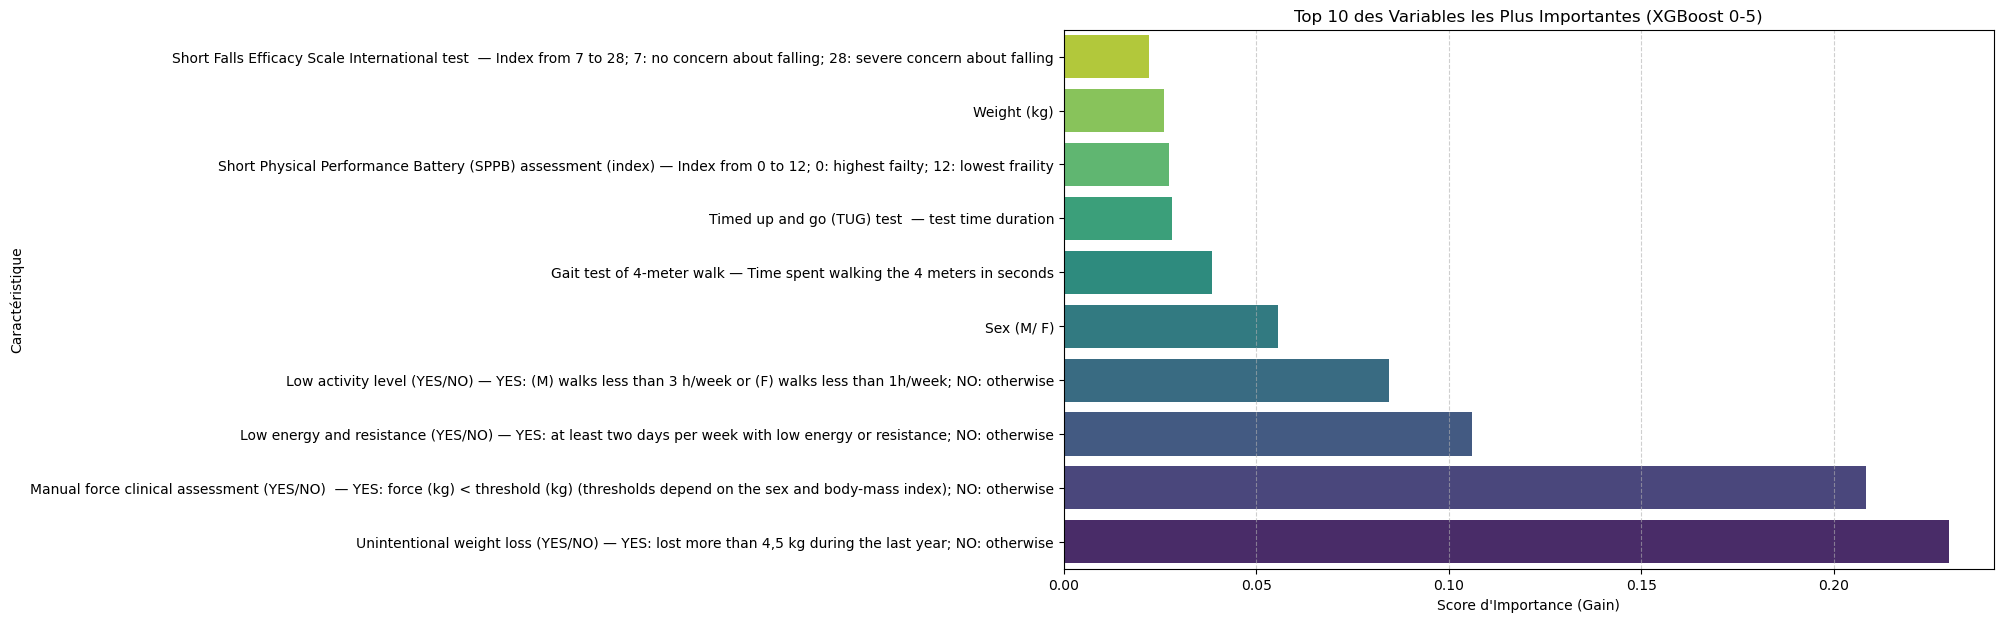

In [15]:
# --- 1. EXTRACTION DU MODÈLE (Maintenir le contexte d'exécution) ---

# Remarque : La variable 'pipeline_xgb_multi' doit être disponible dans l'environnement
# ainsi que 'X_train' (contenant les noms des colonnes de votre dataset).
try:
    # On extrait l'estimateur XGBoost nommé 'xgb' du Pipeline
    modele_xgb = pipeline_xgb_multi.named_steps['xgb'] 
except NameError:
    print("Erreur : La variable 'pipeline_xgb_multi' ou 'X_train' n'a pas été trouvée. Veuillez exécuter à nouveau le code d'entraînement du modèle XGBoost (0-5).")
    exit()

# --- 2. CALCUL ET SÉLECTION DES 10 VARIABLES (GAIN) ---

# XGBoost utilise la méthode 'gain' par défaut pour évaluer l'importance
feature_importances = pd.Series(
    modele_xgb.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False) # Trié en ordre décroissant

# Sélection des 10 variables les plus importantes
top_10_features = feature_importances.head(10)

# --- 3. VISUALISATION (Histogramme horizontal) ---
plt.figure(figsize=(12, 7))

sns.barplot(
    x=top_10_features.values,
    y=top_10_features.index,
    order=top_10_features.index,   # <--- фиксируем порядок вручную
    palette="viridis"
)

# Важные признаки наверху
plt.gca().invert_yaxis()

plt.xlabel("Score d'Importance (Gain)")
plt.ylabel("Caractéristique")
plt.title("Top 10 des Variables les Plus Importantes (XGBoost 0-5)")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

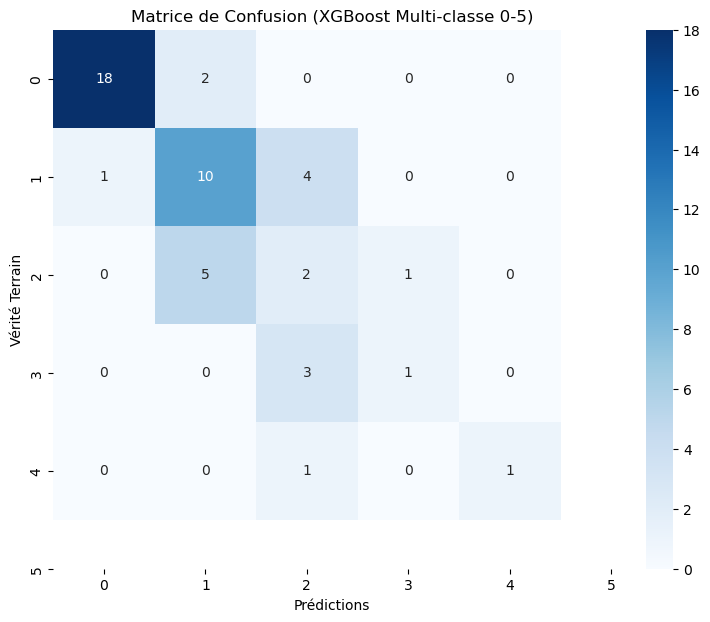

In [ ]:
# On suppose que y_test et predictions sont disponibles depuis l'étape précédente
# 1. Calcul de la matrice de confusion
cm = confusion_matrix(y_test, predictions)
labels = [f'{i}' for i in range(6)]  # Étiquettes pour les axes : 0, 1, 2, 3, 4, 5

# 2. Création de la heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,        # Afficher les nombres
    fmt='d',           # Format des nombres (entiers)
    cmap='Blues',      # Palette de couleurs
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel('Prédictions')
plt.ylabel('Vérité Terrain')
plt.title('Matrice de Confusion (XGBoost Multi-classe 0-5)')
plt.show()

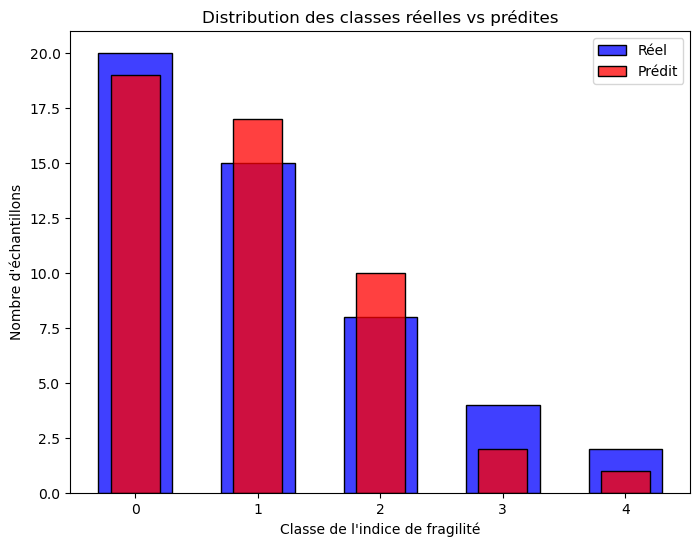

In [19]:
# --- Comparaison des distributions des classes réelles et prédites ---
distribution_df = pd.DataFrame({'Réel': y_test, 'Prédit': predictions})

plt.figure(figsize=(8,6))
sns.histplot(distribution_df, x='Réel', color='blue', label='Réel', discrete=True, shrink=0.6)
sns.histplot(distribution_df, x='Prédit', color='red', label='Prédit', discrete=True, shrink=0.4)
plt.legend()
plt.xlabel('Classe de l\'indice de fragilité')
plt.ylabel('Nombre d\'échantillons')
plt.title('Distribution des classes réelles vs prédites')
plt.show()

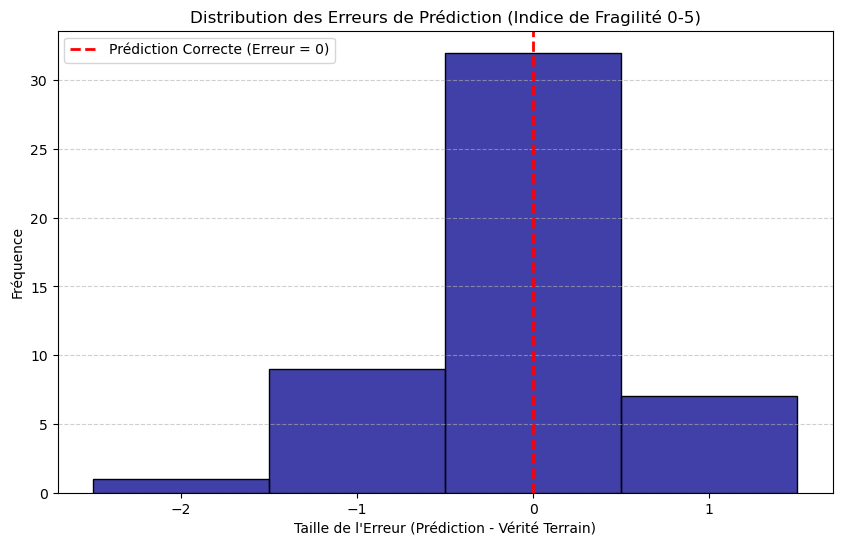

In [ ]:
# On suppose que y_test (indice réel) et predictions (indice prédit) sont disponibles

# 1. Calcul de la différence (erreur)
# Erreur = Prédiction - Réalité
errors = predictions - y_test

# 2. Visualisation de la distribution des erreurs
plt.figure(figsize=(10, 6))
sns.histplot(
    errors,
    bins=np.arange(errors.min() - 0.5, errors.max() + 1.5, 1),  # Centre les barres
    kde=False,
    color='darkblue',
    edgecolor='black'
)

# Ajouter une ligne verticale à zéro
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Prédiction Correcte (Erreur = 0)')

plt.xlabel("Taille de l'Erreur (Prédiction - Vérité Terrain)")
plt.ylabel('Fréquence')
plt.title('Distribution des Erreurs de Prédiction (Indice de Fragilité 0-5)')
plt.xticks(np.arange(errors.min(), errors.max() + 1, 1))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

<Figure size 1200x700 with 0 Axes>

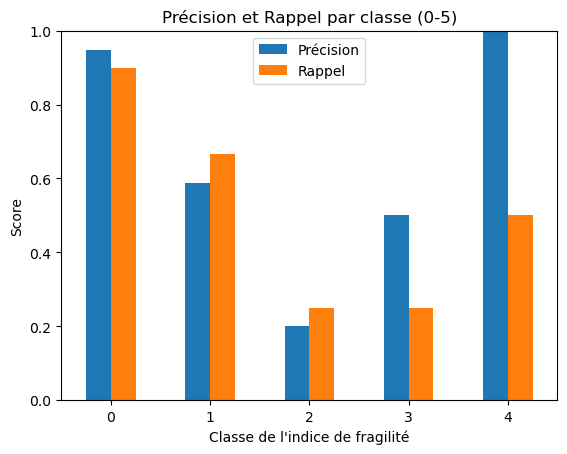

In [ ]:
# Génération du rapport
report_dict = classification_report(y_test, predictions, output_dict=True)

# Conversion en DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Conversion des index en chaînes de caractères pour uniformité
report_df.index = report_df.index.map(str)

# Sélection des métriques precision et recall pour les classes 0-5
classes = ['0', '1', '2', '3', '4', '5']
class_metrics = report_df.loc[classes, ['precision', 'recall']]

# Visualisation
plt.figure(figsize=(12, 7))
class_metrics.plot(kind='bar', rot=0)
plt.title("Précision et Rappel par classe (0-5)")
plt.ylabel("Score")
plt.xlabel("Classe de l'indice de fragilité")
plt.ylim(0, 1)
plt.legend(['Précision', 'Rappel'])
plt.show()

## Évaluation du modèle MLP pour la variable cible Fragilité avec des valeurs possibles 0 ou 1 avec MLP

Chargement réussi du fichier : Données_nettoyées_sans_capteurs____index_de_fragilité_unifiée.csv
--------------------------------------------------

*** Principales métriques de performance (MLP Classifier) ***
Précision Globale (Accuracy)           : 0.9326
Précision pour la Fragilité (classe 1) : 0.9514
Rappel pour la Fragilité (classe 1)    : 0.9389
F1-Score (Fragilité - classe 1)        : 0.9446
Score ROC-AUC                           : 0.9310

Top 10 des variables les plus importantes pour le MLP :
1. Low energy and resistance (YES/NO) — YES: at least two days per week with low energy or resistance; NO: otherwise: 0.1192
2. Manual force clinical assessment (YES/NO)  — YES: force (kg) < threshold (kg) (thresholds depend on the sex and body-mass index); NO: otherwise: 0.0818
3. Low activity level (YES/NO) — YES: (M) walks less than 3 h/week or (F) walks less than 1h/week; NO: otherwise: 0.0545
4. Unintentional weight loss (YES/NO) — YES: lost more than 4,5 kg during the last year; N

C:\Users\Maxime\AppData\Local\Temp\ipykernel_29144\461092124.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


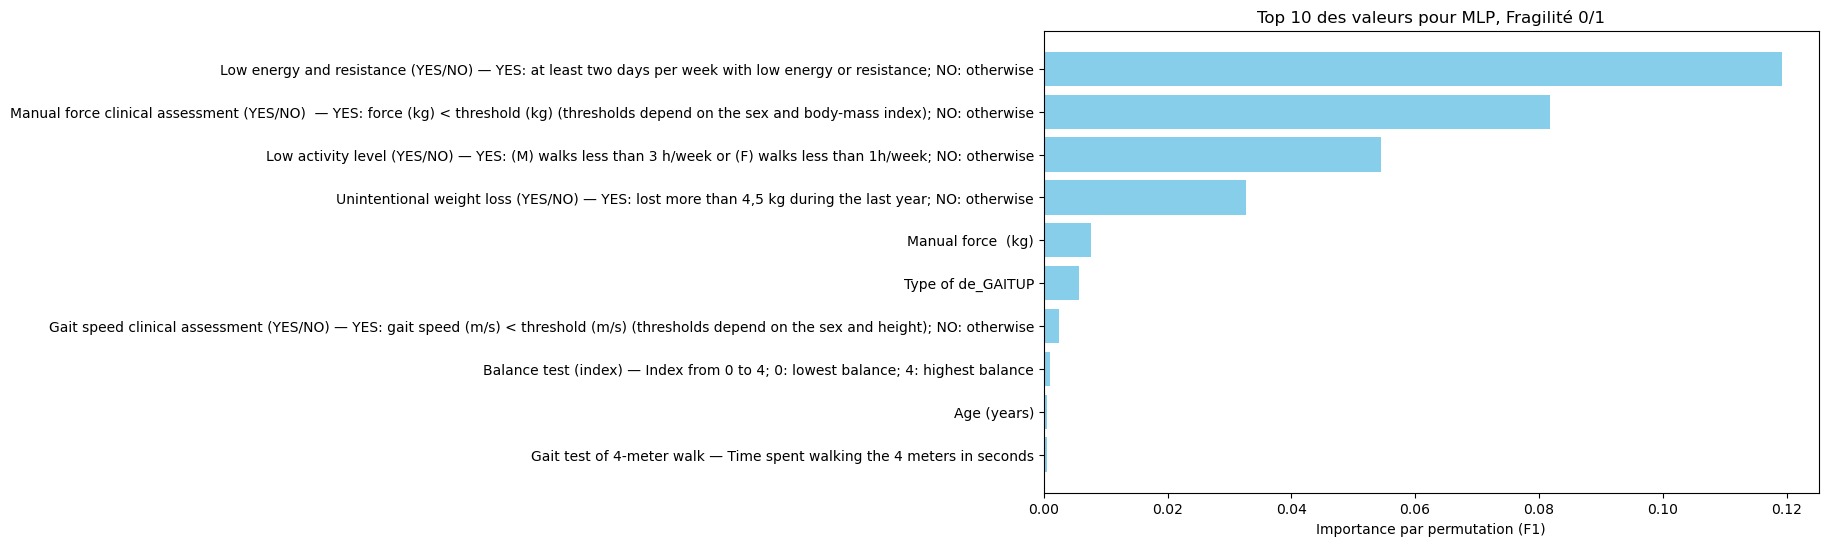

In [14]:
CHEMIN_FICHIER = r'C:\Users\Maxime\Desktop\Fragilité\pack\Données_nettoyées_sans_capteurs____index_de_fragilité_unifiée.csv'
TARGET_COLUMN = 'Frailty index from 0 to 5; 0: lowest failty; 5: highest failty'

try:
    df = pd.read_csv(CHEMIN_FICHIER, sep=';')
    print(f"Chargement réussi du fichier : {os.path.basename(CHEMIN_FICHIER)}")
    print("-" * 50)

except FileNotFoundError:
    print(f"ERREUR : Fichier non trouvé à l'emplacement spécifié : {CHEMIN_FICHIER}")

# --- Données (supposées déjà chargées dans df) ---
target_col = 'Frailty index from 0 to 5; 0: lowest failty; 5: highest failty'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# --- Remplissage des valeurs manquantes ---
for col in X.columns:
    if X[col].dtype in [np.float64, np.int64]:
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0])

# --- Prétraitement + MLP ---
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

mlp = MLPClassifier(hidden_layer_sizes=(100,),
                    max_iter=500,
                    random_state=42,
                    activation='relu',
                    solver='adam')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', mlp)
])

# --- Validation croisée stratifiée K-Fold ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)

# --- Moyennes des métriques de la validation croisée avec des noms explicites ---
accuracy = cv_results['test_accuracy'].mean()
precision_1 = cv_results['test_precision'].mean()
recall_1 = cv_results['test_recall'].mean()
f1_1 = cv_results['test_f1'].mean()
roc_auc = cv_results['test_roc_auc'].mean()

print("\n*** Principales métriques de performance (MLP Classifier) ***")
print(f"Précision Globale (Accuracy)           : {accuracy:.4f}")
print(f"Précision pour la Fragilité (classe 1) : {precision_1:.4f}")
print(f"Rappel pour la Fragilité (classe 1)    : {recall_1:.4f}")
print(f"F1-Score (Fragilité - classe 1)        : {f1_1:.4f}")
print(f"Score ROC-AUC                           : {roc_auc:.4f}")

# --- Entraînement du modèle sur toutes les données pour évaluer l'importance des variables ---
pipeline.fit(X, y)

# --- Importance par permutation ---
result = permutation_importance(pipeline, X, y, n_repeats=10, random_state=42, scoring='f1')

feature_names = X.columns.tolist()
importances = result.importances_mean
indices = np.argsort(importances)[::-1]  # de la plus importante à la moins importante

print("\nTop 10 des variables les plus importantes pour le MLP :")
for i in range(min(10, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# --- Préparation des données pour le graphique ---
top_n = 10
top_features = [feature_names[i] for i in indices[:top_n]]
top_importances = importances[indices[:top_n]]

# --- Diagramme à barres horizontal ---
plt.figure(figsize=(10, 6))
plt.barh(range(top_n-1, -1, -1), top_importances, color='skyblue')  # inversé pour que la variable la plus importante soit en haut
plt.yticks(range(top_n-1, -1, -1), top_features)
plt.xlabel("Importance par permutation (F1)")
plt.title("Top 10 des valeurs pour MLP, Fragilité 0/1")
plt.tight_layout()
plt.show()

## Évaluation du modèle MLP pour la variable cible Fragilité avec des valeurs possibles de 0 à 5 avec MLP


--- Début de l'entraînement du modèle MLP ---
Iteration 1, loss = 1.64649785
Validation score: 0.250000
Iteration 2, loss = 1.57578785
Validation score: 0.250000
Iteration 3, loss = 1.51033222
Validation score: 0.333333
Iteration 4, loss = 1.44986784
Validation score: 0.416667
Iteration 5, loss = 1.39344164
Validation score: 0.416667
Iteration 6, loss = 1.34060467
Validation score: 0.416667
Iteration 7, loss = 1.29151778
Validation score: 0.416667
Iteration 8, loss = 1.24624342
Validation score: 0.416667
Iteration 9, loss = 1.20418496
Validation score: 0.416667
Iteration 10, loss = 1.16532729
Validation score: 0.416667
Iteration 11, loss = 1.12913276
Validation score: 0.416667
Iteration 12, loss = 1.09538961
Validation score: 0.416667
Iteration 13, loss = 1.06405293
Validation score: 0.500000
Iteration 14, loss = 1.03490130
Validation score: 0.583333
Iteration 15, loss = 1.00749749
Validation score: 0.583333
Iteration 16, loss = 0.98111635
Validation score: 0.583333
Iteration 17, loss

C:\Users\Maxime\AppData\Local\Temp\ipykernel_29144\1769694559.py:111: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


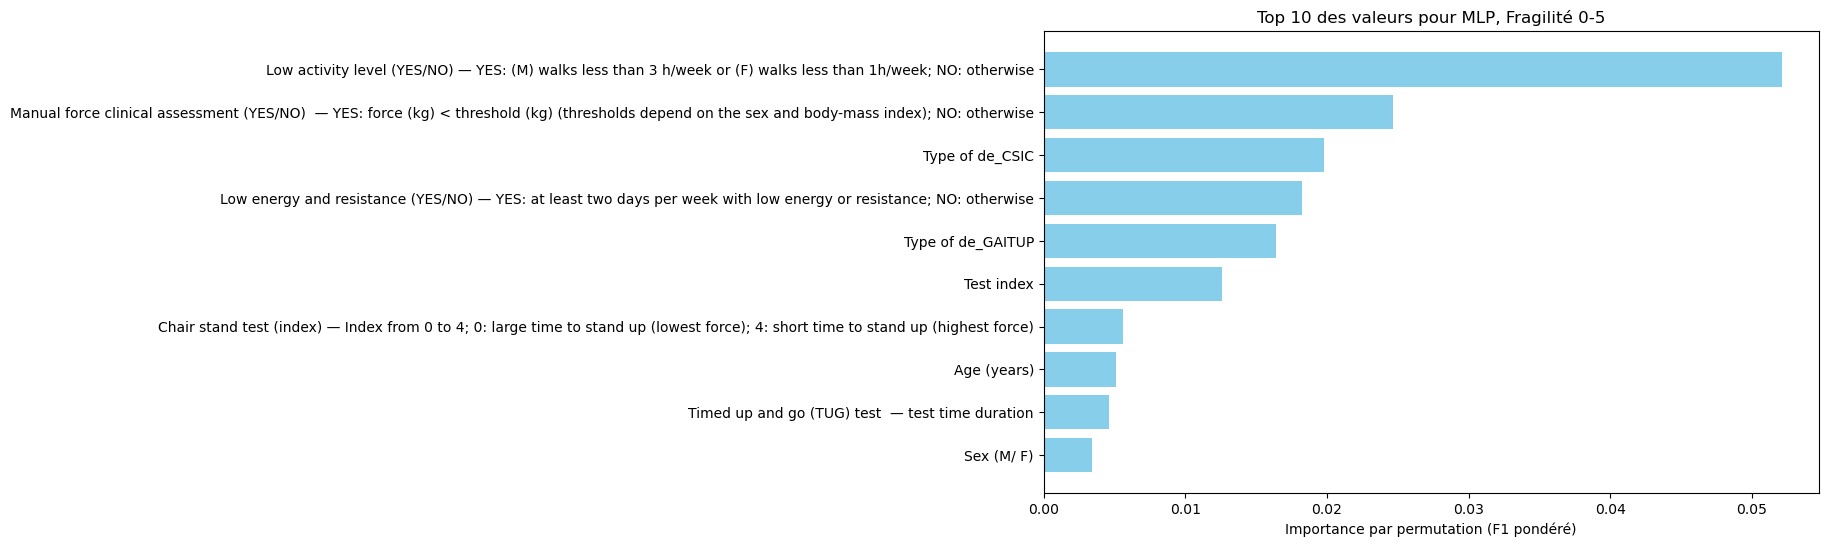

In [15]:
# 1. Chargement et préparation des données
file_name = r'C:\Users\Maxime\Desktop\Fragilité\pack\Données_nettoyées_sans_capteurs_____index_de_fragilité_initial.csv'
data = pd.read_csv(file_name, sep=';')

TARGET_COLUMN = 'Frailty index from 0 to 5; 0: lowest failty; 5: highest failty'

# Définition de la variable cible
X = data.drop(columns=[TARGET_COLUMN])
y = data[TARGET_COLUMN]

# Conversion de la variable cible en entier (important pour la classification)
y = y.astype(int)
X = X.drop(columns=['Test_index'], errors='ignore')

# Traitement des colonnes non numériques (si elles restent)
# Conversion du sexe ('Sex_M__F') en format numérique (M=0, F=1)
if 'Sex_M__F' in X.columns:
    X['Sex_M__F'] = X['Sex_M__F'].replace({'M': 0, 'F': 1}).astype(int)
    
# Conversion des colonnes logiques (OUI/NON) en 1/0
for col in X.columns:
    if X[col].dtype == 'object':
        if all(x in ['YES', 'NO', 'yes', 'no', 'Y', 'N', 'y', 'n'] or pd.isna(x) for x in X[col].unique()):
            X[col] = X[col].replace({'YES': 1, 'NO': 0, 'yes': 1, 'no': 0, 'Y': 1, 'N': 0, 'y': 1, 'n': 0})
            
# Vérification et suppression des lignes avec valeurs manquantes (stratégie simple pour commencer)
X = X.select_dtypes(include=np.number)  # On garde uniquement les colonnes numériques
data_clean = pd.concat([X, y], axis=1).dropna()
X = data_clean.drop(columns=[TARGET_COLUMN])
y = data_clean[TARGET_COLUMN]


# 2. Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y garantit la conservation des proportions de classes dans les deux ensembles

# 3. Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entraînement du modèle MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Deux couches cachées - possibilité d'expérimenter
    max_iter=500,
    activation='relu',
    solver='adam',
    random_state=42,
    verbose=True,
    early_stopping=True  # Arrêt anticipé si la métrique de validation ne s'améliore pas
)

print("\n--- Début de l'entraînement du modèle MLP ---")
mlp.fit(X_train_scaled, y_train)
print("--- Entraînement terminé ---\n")

# Prédiction sur l'ensemble de test
y_pred = mlp.predict(X_test_scaled)


# 5. Évaluation compacte du modèle (5 métriques clés)
# Prédictions du modèle
y_pred = mlp.predict(X_test_scaled)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)

# 2. F1-Score pondéré
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# 3. Erreur absolue moyenne
mae = mean_absolute_error(y_test, y_pred)

# 4. Kappa de Cohen
kappa = cohen_kappa_score(y_test, y_pred)

# Affichage
print("1️⃣ Accuracy :", round(accuracy, 4))
print("2️⃣ F1-Score pondéré :", round(f1_weighted, 4))
print("3️⃣ Erreur absolue moyenne (MAE) :", round(mae, 4))
print("4️⃣ Score Kappa de Cohen :", round(kappa, 4))


# Récupération des noms de features
feature_names = X.columns

# Calcul de l'importance des variables avec Permutation Importance
result = permutation_importance(
    mlp, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, scoring='f1_weighted'
)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]  # Tri décroissant

# --- Affichage des 10 features les plus importantes ---
print("\nTop 10 des variables les plus importantes pour le MLP :")
for i in range(min(10, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# --- Préparation des données pour le graphique ---
top_n = 10
top_features = [feature_names[i] for i in indices[:top_n]]
top_importances = importances[indices[:top_n]]

# --- Diagramme à barres horizontal ---
plt.figure(figsize=(10, 6))
plt.barh(range(top_n-1, -1, -1), top_importances, color='skyblue')  # inversé pour que le plus important soit en haut
plt.yticks(range(top_n-1, -1, -1), top_features)
plt.xlabel("Importance par permutation (F1 pondéré)")
plt.title("Top 10 des valeurs pour MLP, Fragilité 0-5")
plt.tight_layout()
plt.show()